# Massive Mining Datasets - Final Project

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import IntegerType, DoubleType, DateType, StructType, StructField, StringType
from pyspark.sql.functions import col
sc = SparkContext("local", 'FINAL')
sqlc = SQLContext(sc)

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Final Project").getOrCreate()

In [ ]:
MNIST_SMALL_TEST = "/content/drive/MyDrive/MMD Final/Dataset/mnist_small_test.csv"
MNIST_SMALL_TRAIN = "/content/drive/MyDrive/MMD Final/Dataset/mnist_small_train.csv"
RATINGS2K="/content/drive/MyDrive/MMD Final/Dataset/ratings2k.csv"
STOCKHVN2022="/content/drive/MyDrive/MMD Final/Dataset/stockHVN2022.csv"

## Task 1 - Clustering

 YC1_1: Illustration



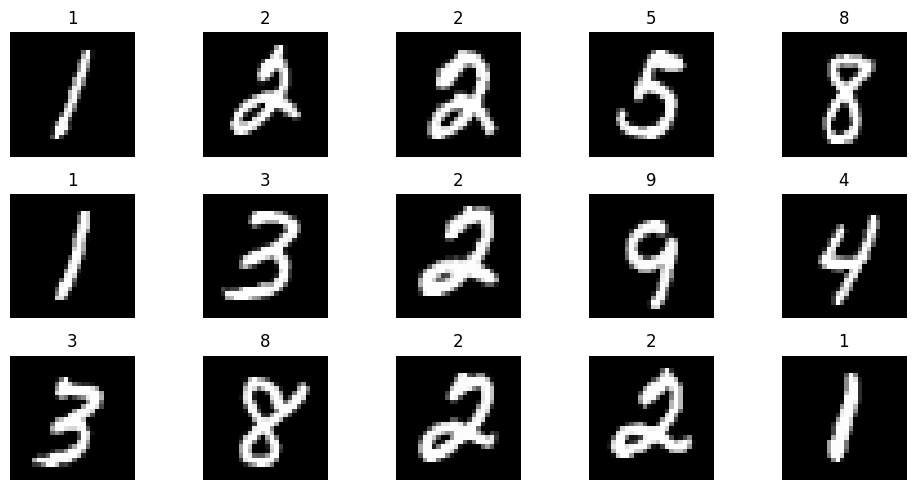

In [ ]:
data = spark.read.csv(MNIST_SMALL_TEST, header=False, inferSchema=True)
import numpy as np
import matplotlib.pyplot as plt
#hàm chuyển đổi dòng dữ liệu thành ma trận 28x28
def row_to_matrix(row):
    return np.array(row[1:]).reshape(28, 28)

# Lấy 15 hàng đầu tiên
first_15_rows = data.take(15)

# Vẽ biểu đồ 3x5 ô hiển thị 15 bức ảnh đầu tiên
fig, axes = plt.subplots(3, 5, figsize=(10, 5))

for i, row in enumerate(first_15_rows):
    ax = axes[i // 5, i % 5]
    ax.imshow(row_to_matrix(row), cmap='gray')
    ax.set_title(f"{row[0]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

YC2_2: Clustering

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

k_values = [5, 10, 15]
models = []
sum_distances_by_cluster = []


# Assemble the feature columns into a single feature vector
assembler = VectorAssembler(inputCols=data.columns[1:], outputCol="features")
feature_data = assembler.transform(data)

for k in k_values:
    # Initialize the KMeans model
    kmeans = KMeans(k=k, seed=1, featuresCol="features", predictionCol="cluster")

    model = kmeans.fit(feature_data)

    # Save the model
    model.write().overwrite().save(f"/content/drive/MyDrive/MMD Final/Models/KMeans_k{k}")

    # Load the model
    loaded_model = KMeansModel.load(f"/content/drive/MyDrive/MMD Final/Models/KMeans_k{k}")

    # Transform data
    transformed_data = loaded_model.transform(feature_data)

    centroids = loaded_model.clusterCenters()

    #Euclidean distance between two points
    def euclidean_distance(a, b):
        return float(np.sqrt(np.sum((a - b) ** 2)))

    # Euclidean distance from each data point to its centroid
    def distance_to_centroid(point, cluster):
        centroid = centroids[cluster]
        return euclidean_distance(point, centroid)

    distance_udf = udf(distance_to_centroid, FloatType())


    # Group by cluster and calculate the sum of Euclidean distances for each cluster
    sum_distances_each_cluster = transformed_data.withColumn("distance", distance_udf(col("features"), col("cluster"))).groupBy("cluster").agg({"distance": "sum"}).collect()

    sum_distances_by_cluster.append(sum_distances_each_cluster)

    # Print the sum of Euclidean distances for each cluster
    print(f"Sum of Euclidean distances for each cluster with k = {k}:")
    for cluster, row in enumerate(sum_distances_each_cluster):
        print(f"Cluster {cluster}: {row['sum(distance)']}")

    models.append(loaded_model)


Sum of Euclidean distances for each cluster with k = 5:
Cluster 0: 1174291.4842529297
Cluster 1: 913983.9670410156
Cluster 2: 516611.9432373047
Cluster 3: 1420087.7631835938
Cluster 4: 933149.6513671875
Sum of Euclidean distances for each cluster with k = 10:
Cluster 0: 706570.1539306641
Cluster 1: 490103.20666503906
Cluster 2: 432860.97509765625
Cluster 3: 693041.939453125
Cluster 4: 462357.0587158203
Cluster 5: 346020.3435058594
Cluster 6: 252442.7745361328
Cluster 7: 307264.5100097656
Cluster 8: 548843.4176025391
Cluster 9: 445594.8786621094
Sum of Euclidean distances for each cluster with k = 15:
Cluster 0: 343654.95166015625
Cluster 1: 304221.66442871094
Cluster 2: 372659.5764160156
Cluster 3: 285011.9180908203
Cluster 4: 286265.71911621094
Cluster 5: 214216.84411621094
Cluster 6: 242486.7515258789
Cluster 7: 253824.81036376953
Cluster 8: 236107.05810546875
Cluster 9: 251174.2205810547
Cluster 10: 389579.6104736328
Cluster 11: 362829.6475830078
Cluster 12: 476429.80993652344
Clust

YC1_3: Result Visualization

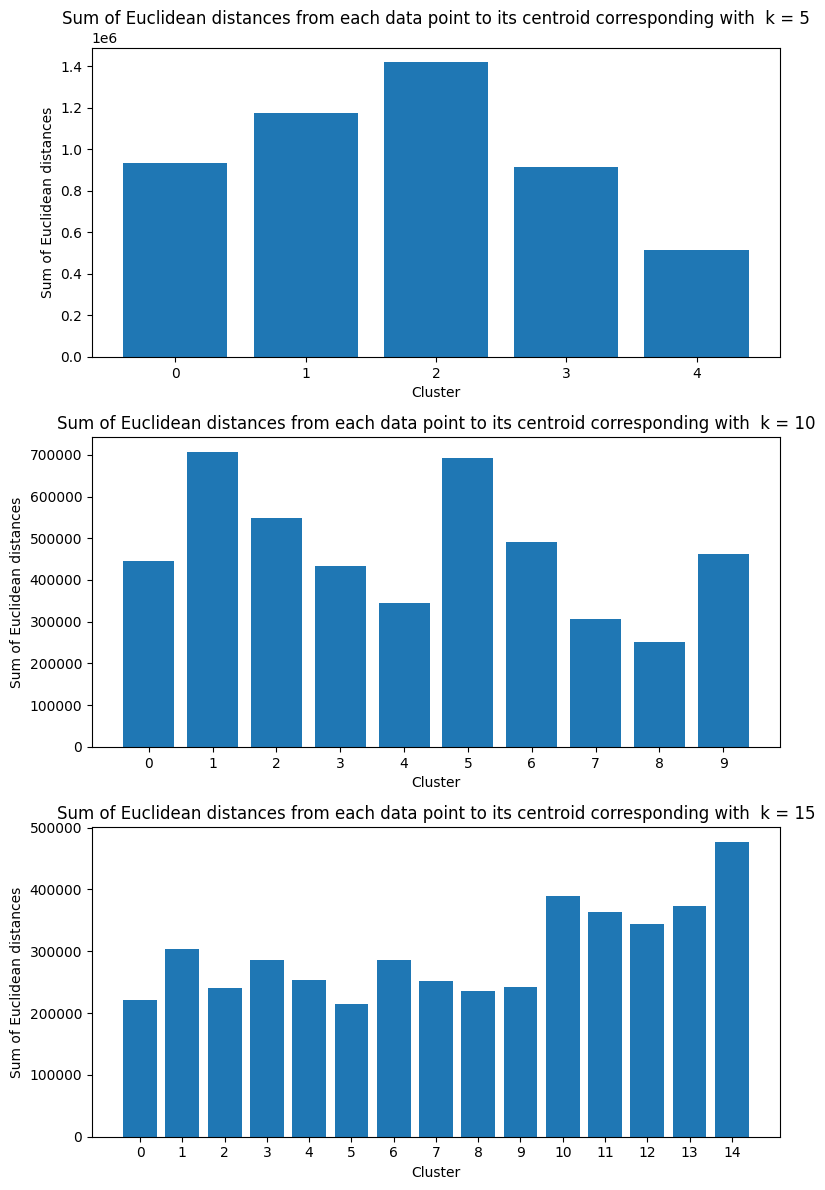

In [ ]:

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

for i, k in enumerate(k_values):
    sum_distances_each_cluster = sum_distances_by_cluster[i]
    cluster_labels = [row["cluster"] for row in sum_distances_each_cluster]
    cluster_distances = [row["sum(distance)"] for row in sum_distances_each_cluster]

    axes[i].bar(cluster_labels, cluster_distances)
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel("Sum of Euclidean distances")
    axes[i].set_title(f"Sum of Euclidean distances from each data point to its centroid corresponding with  k = {k}")
    axes[i].set_xticks(cluster_labels)

plt.tight_layout()
plt.show()

## Task 2 - Dimensionality Reduction



Reuduce dimension Mnist Train



In [ ]:
from pyspark import SparkContext
import numpy as np
from scipy.linalg import svd
import pandas as pd

sc = SparkContext.getOrCreate()
rdd = sc.textFile(MNIST_SMALL_TRAIN)

def parse_row(row):
    return row.split(",")

rdd_parsed = rdd.map(lambda row: parse_row(row))
mnist_data_list_train= rdd_parsed.collect()


In [ ]:
# Chọn số chiều r
r = 196

mnist_labels = [row[0] for row in mnist_data_list_train]  # giử label của các chữ số
mnist_image_vectors = [row[1:] for row in mnist_data_list_train]  # Lấy vector ảnh

# U, S, V_T
U, S, V_T = svd(np.asmatrix(mnist_image_vectors, dtype=int), full_matrices=False)
S = np.diag(S)

mnist_image_vector_matrix_approx = U[:, :r] @ S[:r, :r]
mnist_image_vector_matrix_approx

array([[ 1.05500532e+03, -2.48244718e+02,  5.98132258e+02, ...,
        -6.20233281e+00,  1.63643799e+01, -1.37062359e+01],
       [ 1.39300403e+03,  1.33681947e+02, -1.01833220e+03, ...,
        -5.60301088e+00,  8.28379688e+00, -2.61101310e+01],
       [ 6.48809758e+02, -5.49281895e+02, -4.87342624e+02, ...,
         9.59678610e-01,  6.69134743e+01, -4.95046382e+00],
       ...,
       [ 1.36860863e+03, -8.04714173e+02, -1.10261574e+02, ...,
         1.91372456e+01,  2.69083480e+01,  1.95848523e+01],
       [ 1.66156690e+03, -5.47111909e+02,  6.43050432e+02, ...,
        -3.93830726e+01,  4.21580373e+01, -1.53021308e+01],
       [ 1.28479566e+03, -7.81550433e+02,  1.31658866e+02, ...,
         3.35741604e+00,  2.88577280e+00, -8.79598123e+00]])

In [ ]:
print("Kích thước ma trận sau khi giảm chiều:", mnist_image_vector_matrix_approx.shape)


Kích thước ma trận sau khi giảm chiều: (7000, 196)


In [ ]:
# Kết hợp nhãn với dữ liệu ảnh đã giảm chiều
reduced_data = np.column_stack((mnist_labels, mnist_image_vector_matrix_approx))


# Lưu dữ liệu đã giảm chiều vào tệp CSV
df = pd.DataFrame(reduced_data)
df.to_csv('/content/drive/MyDrive/MMD Final/Dataset/mnist_small_train_svd.csv'.format(r), index=False)



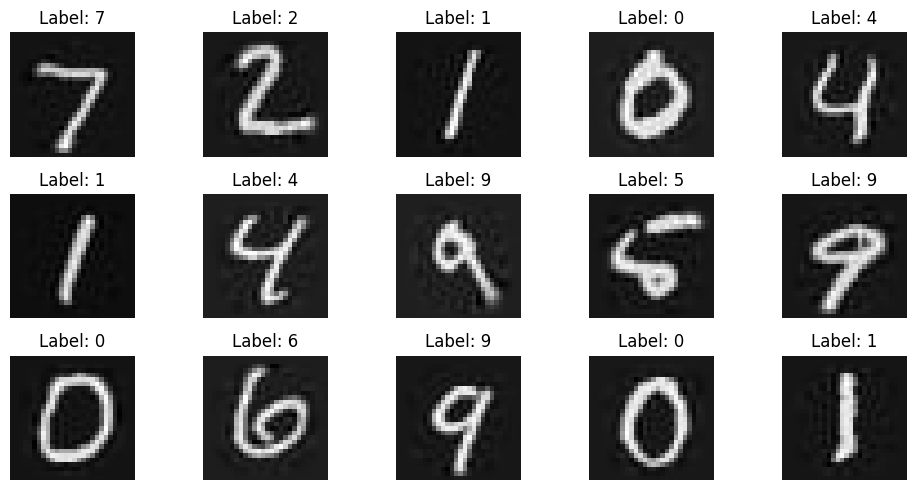

In [ ]:
# Đọc dữ liệu từ tệp CSV đã giảm chiều
reduced_data = pd.read_csv('/content/drive/MyDrive/MMD Final/Dataset/mnist_small_train_svd.csv')
reduced_images = reduced_data.iloc[:, 1:].values

# Tái cấu trúc dữ liệu từ dữ liệu đã giảm chiều
reconstructed_data_from_csv = reduced_images @ V_T[:r, :]

# Lấy 15 hàng đầu tiên từ dữ liệu tái cấu trúc từ file CSV
first_15_rows_reconstructed_from_csv = reconstructed_data_from_csv[:15]

# Vẽ biểu đồ 3x5 ô hiển thị 15 bức ảnh đầu tiên từ dữ liệu tái cấu trúc từ file CSV
fig, axes = plt.subplots(3, 5, figsize=(10, 5))

for i, row in enumerate(first_15_rows_reconstructed_from_csv):
    ax = axes[i // 5, i % 5]
    ax.imshow(row.reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {reduced_data.iloc[i, 0]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


Reuduce dimension Mnist Test


In [ ]:
rdd = sc.textFile(MNIST_SMALL_TEST)

def parse_row(row):
    return row.split(",")

rdd_parsed = rdd.map(lambda row: parse_row(row))
mnist_data_list_test= rdd_parsed.collect()

In [ ]:
# Chọn số chiều r
r = 196

mnist_labels = [row[0] for row in mnist_data_list_test]  # giử label của các chữ số
mnist_image_vectors = [row[1:] for row in mnist_data_list_test]  # Lấy vector ảnh

# U, S, V_T
U, S, V_T = svd(np.asmatrix(mnist_image_vectors, dtype=int), full_matrices=False)
S = np.diag(S)

mnist_image_vector_matrix_approx = U[:, :r] @ S[:r, :r]
mnist_image_vector_matrix_approx

array([[ 7.19336823e+02, -5.17676027e+02,  5.60968574e+02, ...,
         1.90521107e+01, -1.85060983e+00, -1.12854056e+01],
       [ 1.70539033e+03, -2.66338804e+02,  3.32129837e+02, ...,
         2.59313616e+01,  1.70255101e+01,  1.63996514e+01],
       [ 2.21807332e+03,  4.70724328e+01,  2.11541115e+01, ...,
        -4.92595129e+00,  1.36580448e+01,  1.25973923e+01],
       ...,
       [ 1.97116530e+03, -7.21780966e+02, -6.90089932e+02, ...,
        -2.95634384e+01,  5.22279811e+00, -4.05995370e+01],
       [ 1.57827604e+03, -2.33523411e+02,  2.39526167e+01, ...,
         1.16760489e+01,  1.40681769e+01, -1.93961451e+01],
       [ 2.23484806e+03,  1.13948693e+03,  1.50589793e+02, ...,
         1.71125787e+01,  2.72789070e+01, -5.85044355e+01]])

In [ ]:
print("Kích thước ma trận sau khi giảm chiều:", mnist_image_vector_matrix_approx.shape)


Kích thước ma trận sau khi giảm chiều: (3000, 196)


In [ ]:
# Kết hợp nhãn với dữ liệu ảnh đã giảm chiều
reduced_data = np.column_stack((mnist_labels, mnist_image_vector_matrix_approx))

# Lưu dữ liệu đã giảm chiều vào tệp CSV
df = pd.DataFrame(reduced_data)
df.to_csv('/content/drive/MyDrive/MMD Final/Dataset/mnist_small_test_svd.csv'.format(r), index=False)

Tái tạo lại ảnh từ tập giảm chiều đề so sánh với yêu yêu cầu 1

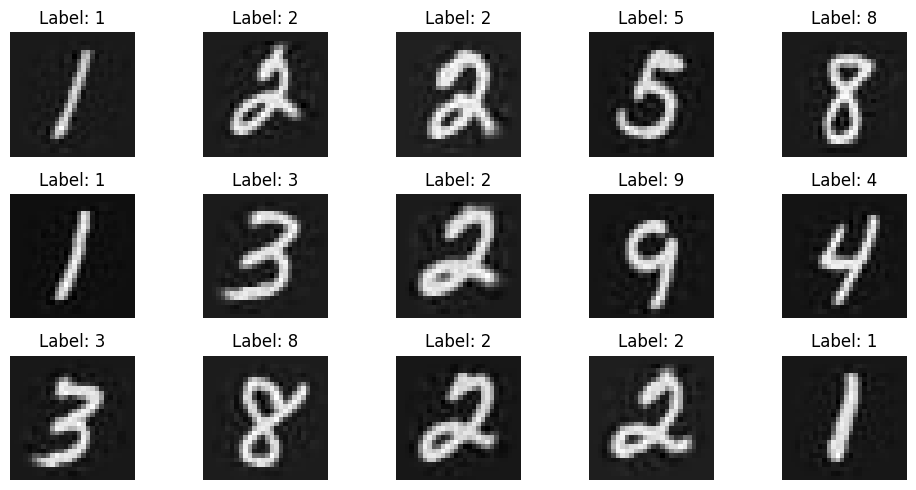

In [ ]:
# Đọc dữ liệu từ tệp CSV đã giảm chiều
reduced_data = pd.read_csv('/content/drive/MyDrive/MMD Final/Dataset/mnist_small_test_svd.csv')
reduced_images = reduced_data.iloc[:, 1:].values

# Tái cấu trúc dữ liệu từ dữ liệu đã giảm chiều
reconstructed_data_from_csv = reduced_images @ V_T[:r, :]

# Lấy 15 hàng đầu tiên từ dữ liệu tái cấu trúc từ file CSV
first_15_rows_reconstructed_from_csv = reconstructed_data_from_csv[:15]

# Vẽ biểu đồ 3x5 ô hiển thị 15 bức ảnh đầu tiên từ dữ liệu tái cấu trúc từ file CSV
fig, axes = plt.subplots(3, 5, figsize=(10, 5))

for i, row in enumerate(first_15_rows_reconstructed_from_csv):
    ax = axes[i // 5, i % 5]
    ax.imshow(row.reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {reduced_data.iloc[i, 0]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


## Task 3 - Recommendation with Collaborative Filtering

In [ ]:
ratings_2k_df = sqlc.read.csv("/content/drive/MyDrive/MMD Final/Dataset/ratings2k.csv", header='true')

In [ ]:
from pyspark.sql.types import IntegerType, DoubleType, DateType, StructType, StructField, StringType
from pyspark.sql.functions import col

# Cast columns to appropriate data types
ratings_2k_df = ratings_2k_df.withColumn("user", col("user").cast(IntegerType()))
ratings_2k_df = ratings_2k_df.withColumn("item", col("item").cast(IntegerType()))
ratings_2k_df = ratings_2k_df.withColumn("rating", col("rating").cast(DoubleType()))

# Remove duplicates and filter out null ratings
ratings_2k_df = ratings_2k_df.dropDuplicates()
ratings_2k_df = ratings_2k_df.filter(col("rating").isNotNull())

# Sort the dataframe by user
ratings_2k_df = ratings_2k_df.sort(col("user"))

ratings_2k_df.limit(10).show()

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
| 1544|   1| 163|   5.0|
|  390|   1| 352|   5.0|
|   32|   1| 167|   3.5|
| 1188|   1| 168|   5.0|
|  130|   1| 422|   3.5|
| 2274|   2| 456|   4.5|
| 1108|   2| 310|   2.0|
| 1949|   2| 148|   1.0|
| 2035|   2| 145|   0.5|
|  238|   2| 434|   4.0|
+-----+----+----+------+



In [ ]:
# Split the ratings data of user into training and test sets
(train_recommend, test_recommend) = ratings_2k_df.randomSplit([0.9, 0.1])

In [ ]:
# Import the necessary modules
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col,lit

# Create an ALS model with userCol, itemCol and ratingCol
als = ALS(rank=10,
          regParam=0.01,
          maxIter=5,
          userCol="user",
          itemCol="item",
          ratingCol="rating",
          coldStartStrategy="drop",
          nonnegative=True)

# Fit the model on the train set
model = als.fit(train_recommend)

# Generate predictions for the test set (remaining users)
predictions = model.transform(test_recommend)

userRecs = model.recommendForAllUsers(10)
userRecs.show(10)

+----+--------------------+
|user|     recommendations|
+----+--------------------+
|  31|[{383, 4.610165},...|
|  65|[{176, 0.999579},...|
|  53|[{26, 7.2327414},...|
|  34|[{271, 8.185037},...|
|  28|[{42, 8.095174}, ...|
|  26|[{35, 9.171745}, ...|
|  27|[{44, 8.900645}, ...|
|  44|[{439, 4.729614},...|
|  12|[{99, 5.169511}, ...|
|  22|[{258, 6.820038},...|
+----+--------------------+
only showing top 10 rows



In [ ]:
# user and items ratings - train set
ratings_2k_users_df = ratings_2k_df.where((col("user") >= 71) & (col("item") >= 401))

In [ ]:
# Split the ratings data of user into training and test sets
(train, test) = ratings_2k_users_df.randomSplit([0.6, 0.4])

In [ ]:
# Fit the model on the train set
model = als.fit(train)

# Generate predictions for the test set (remaining users)
predictions = model.transform(test)

# Show predictions
predictions.limit(10).show()

# Evaluate the model using RMSE metric
evaluator_user = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
mse = evaluator_user.evaluate(predictions)
print(f"Mean-square error = {mse}")

+-----+----+----+------+----------+
|index|user|item|rating|prediction|
+-----+----+----+------+----------+
| 1585|  72| 412|   3.0|0.38834378|
|  299|  73| 417|   3.0|0.19600762|
+-----+----+----+------+----------+

Mean-square error = 7.341560724092707


In [ ]:
from pyspark.sql.functions import corr
#Calculate Pearson correlation coefficient
ratings_2k_df.stat.corr("user", "rating")

-0.040232749678382654

## Task 4 - Stock Price Regression

In [ ]:
stock_hvn_df = sqlc.read.csv('/content/drive/MyDrive/MMD Final/Dataset/stockHVN2022.csv', header='true')

In [ ]:
stock_hvn_df.limit(10).show()

+----------+-----+
|      Ngay|  HVN|
+----------+-----+
|18/11/2022| 9.30|
|17/11/2022| 9.42|
|16/11/2022| 9.21|
|15/11/2022| 8.61|
|14/11/2022| 9.25|
|11/11/2022| 9.90|
|10/11/2022| 9.76|
|09/11/2022|10.40|
|08/11/2022|10.25|
|07/11/2022|10.10|
+----------+-----+



In [ ]:
# Convert dataframe to list
stock_hvn_list = stock_hvn_df.collect()

# Define filter function
def is_training(row):
    return int(row[0].split("/")[1]) < 7

# Split to train and test set using filter function and list comprehension
train_list = [row for row in stock_hvn_list if is_training(row)]
test_list = [row for row in stock_hvn_list if not is_training(row)]

In [ ]:
# Import necessary modules and create a SparkSession with the name "CK"
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('CK').getOrCreate()

# Create an empty RDD
emptyRDD = spark.sparkContext.emptyRDD()

# Define the schema for the dataframes
schema = StructType([
  StructField('5_prev_days', StringType(), True),
  StructField('5_prev_days_price', StringType(), True),
  StructField('today_price', DoubleType(), True)
])

In [ ]:
# Create two dataframes with the same schema but no data
stock_hvn_train_df = spark.createDataFrame(emptyRDD, schema)
stock_hvn_test_df = spark.createDataFrame(emptyRDD, schema)

In [ ]:
columns = ['5_prev_days', '5_prev_days_price', 'today']
# Traing set processing
def fill_5_prev_days_price(df, columns, source_list):
    """
    Function Objective: Is used to fill 5 previous days' prices in 1 cell
    """
    new_rows = []
    for i in range(len(source_list)-5):
        # date
        append_date = ",".join(row[0] for row in source_list[i:i+5])
        # price
        append_price = ",".join(row[1] for row in source_list[i:i+5])
        # real price
        today = source_list[i+5][1]
        # Create a new row with the concatenated date and price columns
        new_row = (append_date, append_price, today)
        new_rows.append(new_row)
    # Create a new dataframe with the new rows and add it to the original dataframe
    new_df = spark.createDataFrame(new_rows, columns)
    df = df.union(new_df)
    return df

In [ ]:
# Apply the fill_5_prev_days_price function to the training and test dataframes
stock_hvn_train_df = fill_5_prev_days_price(stock_hvn_train_df, columns, train_list)
stock_hvn_test_df = fill_5_prev_days_price(stock_hvn_test_df, columns, test_list)

In [ ]:
from pyspark.sql import functions as f
from pyspark.ml.functions import array_to_vector

# Convert string to Vector
stock_hvn_train_df = stock_hvn_train_df.withColumn("5_prev_days_price", array_to_vector(f.split('5_prev_days_price', ',[ ]*').cast('array<double>')))
stock_hvn_test_df = stock_hvn_test_df.withColumn("5_prev_days_price", array_to_vector(f.split('5_prev_days_price', ',[ ]*').cast('array<double>')))
# Convert string to Double
stock_hvn_train_df = stock_hvn_train_df.withColumn("today_price",f.col("today_price").cast('double'))
stock_hvn_test_df = stock_hvn_test_df.withColumn("today_price",f.col("today_price").cast('double'))
# Drop column 5_prev_days
stock_hvn_train_df = stock_hvn_train_df.drop(col("5_prev_days"))
stock_hvn_test_df = stock_hvn_test_df.drop(col("5_prev_days"))

In [ ]:
#Show the first few rows of the training dataframe
stock_hvn_train_df.limit(10).show()

+--------------------+-----------+
|   5_prev_days_price|today_price|
+--------------------+-----------+
|[15.5,16.05,16.5,...|       15.3|
|[16.05,16.5,16.3,...|      15.35|
|[16.5,16.3,15.25,...|      14.95|
|[16.3,15.25,15.3,...|       14.6|
|[15.25,15.3,15.35...|       15.6|
|[15.3,15.35,14.95...|      16.25|
|[15.35,14.95,14.6...|      16.15|
|[14.95,14.6,15.6,...|       17.1|
|[14.6,15.6,16.25,...|       17.1|
|[15.6,16.25,16.15...|       18.0|
+--------------------+-----------+



In [ ]:
stock_hvn_test_df.limit(10).show()

+--------------------+-----------+
|   5_prev_days_price|today_price|
+--------------------+-----------+
|[9.3,9.42,9.21,8....|        9.9|
|[9.42,9.21,8.61,9...|       9.76|
|[9.21,8.61,9.25,9...|       10.4|
|[8.61,9.25,9.9,9....|      10.25|
|[9.25,9.9,9.76,10...|       10.1|
|[9.9,9.76,10.4,10...|       10.7|
|[9.76,10.4,10.25,...|      10.85|
|[10.4,10.25,10.1,...|       10.9|
|[10.25,10.1,10.7,...|       10.9|
|[10.1,10.7,10.85,...|       10.8|
+--------------------+-----------+



In [ ]:
stock_hvn_train_df.write.mode('overwrite').parquet('/content/drive/MyDrive/MMD Final/Dataset/train_dataframe.parquet')
stock_hvn_test_df.write.mode('overwrite').parquet('/content/drive/MyDrive/MMD Final/Dataset/test_dataframe.parquet')

In [ ]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

# Creating a Linear Regression object and specifying the feature and label columns
lr = LinearRegression(featuresCol='5_prev_days_price', labelCol='today_price')

In [ ]:
# Training the Linear Regression model on the training dataset
lr_model = lr.fit(stock_hvn_train_df)

# Save the trained model
model_path = '/content/drive/MyDrive/MMD Final/Models'
lr_model.write().overwrite().save(model_path)

In [ ]:
# Load the saved model
lr_model_loaded = LinearRegressionModel.load(model_path)

In [ ]:
# Using the loaded model to make predictions on the training and test datasets
train_preds = lr_model_loaded.transform(stock_hvn_train_df.select('5_prev_days_price'))
test_preds = lr_model_loaded.transform(stock_hvn_test_df.select('5_prev_days_price'))

# Displaying the predictions of the training dataset
print('Train prediction')
train_preds.limit(10).show()
# Displaying the predictions of the test dataset
print('Test prediction')
test_preds.limit(10).show()

Train prediction
+--------------------+------------------+
|   5_prev_days_price|        prediction|
+--------------------+------------------+
|[15.5,16.05,16.5,...| 15.54237094995805|
|[16.05,16.5,16.3,...|15.732636961806806|
|[16.5,16.3,15.25,...|15.549383516801464|
|[16.3,15.25,15.3,...|15.018480621394549|
|[15.25,15.3,15.35...|14.897919441472887|
|[15.3,15.35,14.95...|15.955105153888548|
|[15.35,14.95,14.6...| 16.35176996198033|
|[14.95,14.6,15.6,...| 16.27045143430231|
|[14.6,15.6,16.25,...|17.550259857457718|
|[15.6,16.25,16.15...|17.302119256904334|
+--------------------+------------------+

Test prediction
+--------------------+------------------+
|   5_prev_days_price|        prediction|
+--------------------+------------------+
|[9.3,9.42,9.21,8....| 9.794556489594813|
|[9.42,9.21,8.61,9...|10.238932612580003|
|[9.21,8.61,9.25,9...|10.008296053501235|
|[8.61,9.25,9.9,9....|10.961240836061616|
|[9.25,9.9,9.76,10...|10.661777249280872|
|[9.9,9.76,10.4,10...|10.492776638356501|


In [ ]:
# Calculating the mean squared error (MSE) of the predictions for the training and test datasets
train_mse = lr_model_loaded.evaluate(stock_hvn_train_df)
test_mse = lr_model_loaded.evaluate(stock_hvn_test_df)
train_mse = train_mse.meanSquaredError
test_mse = test_mse.meanSquaredError

print('Train Mean Square Error: ',  train_mse)
print('Test Mean Square Error: ', test_mse)

Train Mean Square Error:  0.22674891148810883
Test Mean Square Error:  0.14708129147246438


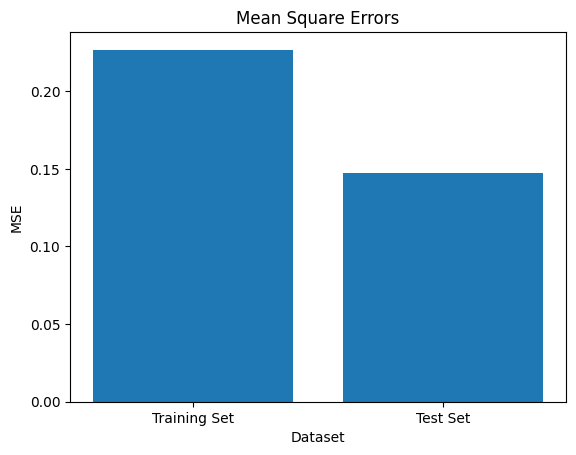

In [ ]:
# Visualize mean square errors using a bar chart
mse_values = [train_mse, test_mse]
labels = ['Training Set', 'Test Set']
plt.bar(labels, mse_values)
plt.title('Mean Square Errors')
plt.xlabel('Dataset')
plt.ylabel('MSE')
plt.show()

## Task 5 - Multi-class Classification




Multi-layer Perceptron

In [ ]:
import math
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.sql.types import StructType, FloatType

def MLB(train, test, r):
  imageLabel = ['label']
  train_labels = [row[0] for row in train.select("_c0").collect()]
  test_labels = [row[0] for row in test.select("_c0").collect()]
  for i in range(1,int(math.sqrt(r)) + 1):
    for j in range(1,int(math.sqrt(r)) + 1):
      imageLabel.append(str(i) + 'x' + str(j))

  train = train.toDF(*imageLabel)
  test = test.toDF(*imageLabel)
  assembler = VectorAssembler(inputCols=train.columns[1:], outputCol='features')
  train = assembler.transform(train)
  test = assembler.transform(test)

  # Define MLP model
  layers = [r, 50, 10]
  mlp = MultilayerPerceptronClassifier(layers=layers, seed=42)

  # Train MLP model
  model = mlp.fit(train)

  # Evaluate MLP model on test dataset and train dataset
  test_predictions = model.transform(test)
  train_predictions = model.transform(train)
  evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
  test_accuracy = evaluator.evaluate(test_predictions)
  train_accuracy = evaluator.evaluate(train_predictions)

  schema = StructType([
    StructField("label", FloatType(), True),
    StructField("predicted", FloatType(), True)
  ])

  print("Train Prediction")
  train_predicted = train_predictions.select("prediction").rdd.map(lambda x: x[0]).collect()
  train_label_predicted = [(train_labels[i], train_predicted[i]) for i in range(len(train_predicted))]
  train_label_predicted_df = spark.createDataFrame(train_label_predicted, schema=schema)
  train_label_predicted_df.show(5)

  print("Test Prediction")
  test_predicted = test_predictions.select("prediction").rdd.map(lambda x: x[0]).collect()
  test_label_predicted = [(test_labels[i], test_predicted[i]) for i in range(len(test_predicted))]
  test_label_predicted_df = spark.createDataFrame(test_label_predicted, schema=schema)
  test_label_predicted_df.show(5)

  return [round(train_accuracy * 100, 2), round(test_accuracy * 100, 2)]

Random Forest


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def RandomForest(train, test, r):
  imageLabel = ['label']
  train_labels = [row[0] for row in train.select("_c0").collect()]
  test_labels = [row[0] for row in test.select("_c0").collect()]
  for i in range(1,int(math.sqrt(r)) + 1):
    for j in range(1,int(math.sqrt(r)) + 1):
      imageLabel.append(str(i) + 'x' + str(j))

  train = train.toDF(*imageLabel)
  test = test.toDF(*imageLabel)

  # Split the dataset into training and test sets
  train_df = train
  test_df = test

  # Define the input and output columns
  input_cols = train.columns[1:]
  output_col = "label"

  # Vectorize the input columns
  assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
  train_vector_df = assembler.transform(train_df)
  test_vector_df = assembler.transform(test_df)

  # Train the random forest model
  rf = RandomForestClassifier(numTrees=10, maxDepth=10, seed=42)
  rf_model = rf.fit(train_vector_df)

  # Make predictions on the test set
  train_predictions_df = rf_model.transform(train_vector_df)
  test_predictions_df = rf_model.transform(test_vector_df)
  # Evaluate the model using accuracy
  evaluator = MulticlassClassificationEvaluator(labelCol=output_col, predictionCol="prediction", metricName="accuracy")
  train_accuracy = evaluator.evaluate(train_predictions_df)
  test_accuracy = evaluator.evaluate(test_predictions_df)

  schema = StructType([
    StructField("label", FloatType(), True),
    StructField("predicted", FloatType(), True)
  ])

  print("Train Prediction")
  train_predicted = train_predictions_df.select("prediction").rdd.map(lambda x: x[0]).collect()
  train_label_predicted = [(train_labels[i], train_predicted[i]) for i in range(len(train_predicted))]
  train_label_predicted_df = spark.createDataFrame(train_label_predicted, schema=schema)
  train_label_predicted_df.show(5)

  print("Test Prediction")
  test_predicted = test_predictions_df.select("prediction").rdd.map(lambda x: x[0]).collect()
  test_label_predicted = [(test_labels[i], test_predicted[i]) for i in range(len(test_predicted))]
  test_label_predicted_df = spark.createDataFrame(test_label_predicted, schema=schema)
  test_label_predicted_df.show(5)

  return [round(train_accuracy * 100, 2), round(test_accuracy * 100, 2)]


Linear Support Vector Machine

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def LSVM(train, test, r):
  imageLabel = ['label']
  train_labels = [row[0] for row in train.select("_c0").collect()]
  test_labels = [row[0] for row in test.select("_c0").collect()]
  for i in range(1,int(math.sqrt(r)) + 1):
    for j in range(1,int(math.sqrt(r)) + 1):
      imageLabel.append(str(i) + 'x' + str(j))

  train = train.toDF(*imageLabel)
  test = test.toDF(*imageLabel)


  assembler = VectorAssembler(inputCols=train.columns[1:], outputCol='features')
  train_data = assembler.transform(train)
  test_data = assembler.transform(test)

  svm = LinearSVC(maxIter=10, regParam=0.1)

  ovr = OneVsRest(classifier=svm, labelCol='label')
  ovr_model = ovr.fit(train_data)

  train_predictions = ovr_model.transform(train_data)
  test_predictions = ovr_model.transform(test_data)


  evaluator = MulticlassClassificationEvaluator(labelCol='label')
  train_accuracy = evaluator.evaluate(train_predictions, {evaluator.metricName: 'accuracy'})
  test_accuracy = evaluator.evaluate(test_predictions, {evaluator.metricName: 'accuracy'})

  schema = StructType([
    StructField("label", FloatType(), True),
    StructField("predicted", FloatType(), True)
  ])

  print("Train Prediction")
  train_predicted = train_predictions.select("prediction").rdd.map(lambda x: x[0]).collect()
  train_label_predicted = [(train_labels[i], train_predicted[i]) for i in range(len(train_predicted))]
  train_label_predicted_df = spark.createDataFrame(train_label_predicted, schema=schema)
  train_label_predicted_df.show(5)

  print("Test Prediction")
  test_predicted = test_predictions.select("prediction").rdd.map(lambda x: x[0]).collect()
  test_label_predicted = [(test_labels[i], test_predicted[i]) for i in range(len(test_predicted))]
  test_label_predicted_df = spark.createDataFrame(test_label_predicted, schema=schema)
  test_label_predicted_df.show(5)

  return [round(train_accuracy * 100, 2), round(test_accuracy * 100, 2)]



In [ ]:
# Mnist Small Test Dataframe for Multi-layer Perceptron
mnist_small_test_df = sqlc.read.csv("/content/drive/MyDrive/MMD Final/Dataset/mnist_small_test.csv", header=False, inferSchema=True)
mnist_small_test_df = mnist_small_test_df.select([col(c).cast("double") for c in mnist_small_test_df.columns])

# Mnist Small Train Dataframe for Multi-layer Perceptron
mnist_small_train_df = sqlc.read.csv("/content/drive/MyDrive/MMD Final/Dataset/mnist_small_train.csv", header=False, inferSchema=True)
mnist_small_train_df = mnist_small_train_df.select([col(c).cast("double") for c in mnist_small_train_df.columns])

# Mnist Small Train SVD for Multi-layer Perceptron
mnist_small_train_SVD_df = sqlc.read.csv("/content/drive/MyDrive/MMD Final/Dataset/mnist_small_train_svd.csv", header=False, inferSchema=True)
mnist_small_train_SVD_df = mnist_small_train_SVD_df.rdd.zipWithIndex().filter(lambda x: x[1] > 0).map(lambda x: x[0]).toDF(mnist_small_train_SVD_df.columns)
mnist_small_train_SVD_df = mnist_small_train_SVD_df.select([col(c).cast("double") for c in mnist_small_train_SVD_df.columns])

# Mnist Small Test SVD for Multi-layer Perceptron
mnist_small_test_SVD_df = sqlc.read.csv("/content/drive/MyDrive/MMD Final/Dataset/mnist_small_test_svd.csv", header=False, inferSchema=True)
mnist_small_test_SVD_df = mnist_small_test_SVD_df.rdd.zipWithIndex().filter(lambda x: x[1] > 0).map(lambda x: x[0]).toDF(mnist_small_test_SVD_df.columns)
mnist_small_test_SVD_df = mnist_small_test_SVD_df.select([col(c).cast("double") for c in mnist_small_test_SVD_df.columns])

In [ ]:
# Get Multi-layer Perceptron Accuracy
print("MLB Prediction for MNIST Small")
MLB_Accuracy = MLB(mnist_small_train_df, mnist_small_test_df, 784)
print("MLB Prediction for MNIST Small SVD")
MLB_SVD_Accuracy = MLB(mnist_small_train_SVD_df, mnist_small_test_SVD_df, 196)

# Get Random Forest Accuracy
print("Random Forest Prediction for MNIST Small")
RF_Accuracy = RandomForest(mnist_small_train_df, mnist_small_test_df, 784)
print("Random Forest Prediction for MNIST Small SVD")
RF_SVD_Accuracy = RandomForest(mnist_small_train_SVD_df, mnist_small_test_SVD_df, 196)

# Get Linear Support Vector Machine Accuracy
print("Linear Support Vector Machine Prediction for MNIST Small ")
LSVM_Accuracy = LSVM(mnist_small_train_df, mnist_small_test_df, 784)
print("Linear Support Vector Machine Prediction for MNIST Small SVD")
LSVM_SVD_Accuracy = LSVM(mnist_small_train_SVD_df, mnist_small_test_SVD_df, 196)

MLB Prediction for MNIST Small
Train Prediction
+-----+---------+
|label|predicted|
+-----+---------+
|  7.0|      7.0|
|  2.0|      2.0|
|  1.0|      1.0|
|  0.0|      0.0|
|  4.0|      4.0|
+-----+---------+
only showing top 5 rows

Test Prediction
+-----+---------+
|label|predicted|
+-----+---------+
|  1.0|      1.0|
|  2.0|      2.0|
|  2.0|      2.0|
|  5.0|      5.0|
|  8.0|      8.0|
+-----+---------+
only showing top 5 rows

MLB Prediction for MNIST Small SVD
Train Prediction
+-----+---------+
|label|predicted|
+-----+---------+
|  7.0|      7.0|
|  2.0|      2.0|
|  1.0|      1.0|
|  0.0|      0.0|
|  4.0|      4.0|
+-----+---------+
only showing top 5 rows

Test Prediction
+-----+---------+
|label|predicted|
+-----+---------+
|  1.0|      7.0|
|  2.0|      9.0|
|  2.0|      8.0|
|  5.0|      2.0|
|  8.0|      4.0|
+-----+---------+
only showing top 5 rows

Random Forest Prediction for MNIST Small
Train Prediction
+-----+---------+
|label|predicted|
+-----+---------+
|  7.0| 

Draw Chart

90.43 89.93 90.43 13.37
98.2 91.93 95.16 9.63
86.11 86.47 86.77 10.4


<function matplotlib.pyplot.show(close=None, block=None)>

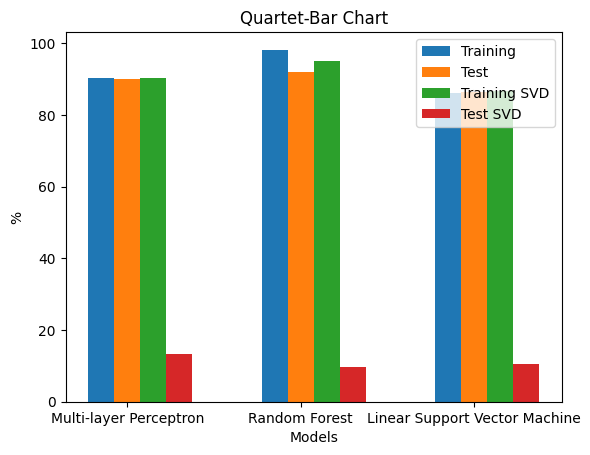

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data1 = [MLB_Accuracy[0], RF_Accuracy[0], LSVM_Accuracy[0]]
data2 = [MLB_Accuracy[1], RF_Accuracy[1], LSVM_Accuracy[1]]
data3 = [MLB_SVD_Accuracy[0], RF_SVD_Accuracy[0], LSVM_SVD_Accuracy[0]]
data4 = [MLB_SVD_Accuracy[1], RF_SVD_Accuracy[1], LSVM_SVD_Accuracy[1]]


for i in range(0,3):
  print(data1[i], data2[i], data3[i], data4[i])

labels = ['Multi-layer Perceptron', 'Random Forest', 'Linear Support Vector Machine']

width = 0.15

x1 = np.arange(len(data1))
x2 = [x + width for x in x1]
x3 = [x + width for x in x2]
x4 = [x + width for x in x3]

plt.bar(x1, data1, width=width, label='Training')
plt.bar(x2, data2, width=width, label='Test')
plt.bar(x3, data3, width=width, label='Training SVD')
plt.bar(x4, data4, width=width, label='Test SVD')

plt.xlabel('Models')
plt.ylabel('%')
plt.title('Quartet-Bar Chart')

plt.xticks([x + width for x in range(len(data1))], labels)

plt.legend()

plt.show
